**Projet IA BIG DATA**


Lors de ce projet nous avions un dataset chest_Xray qui contenait des dossiers train,val et test et nous devions implémenter un algorithme de reconnaissance de d'image



Normal
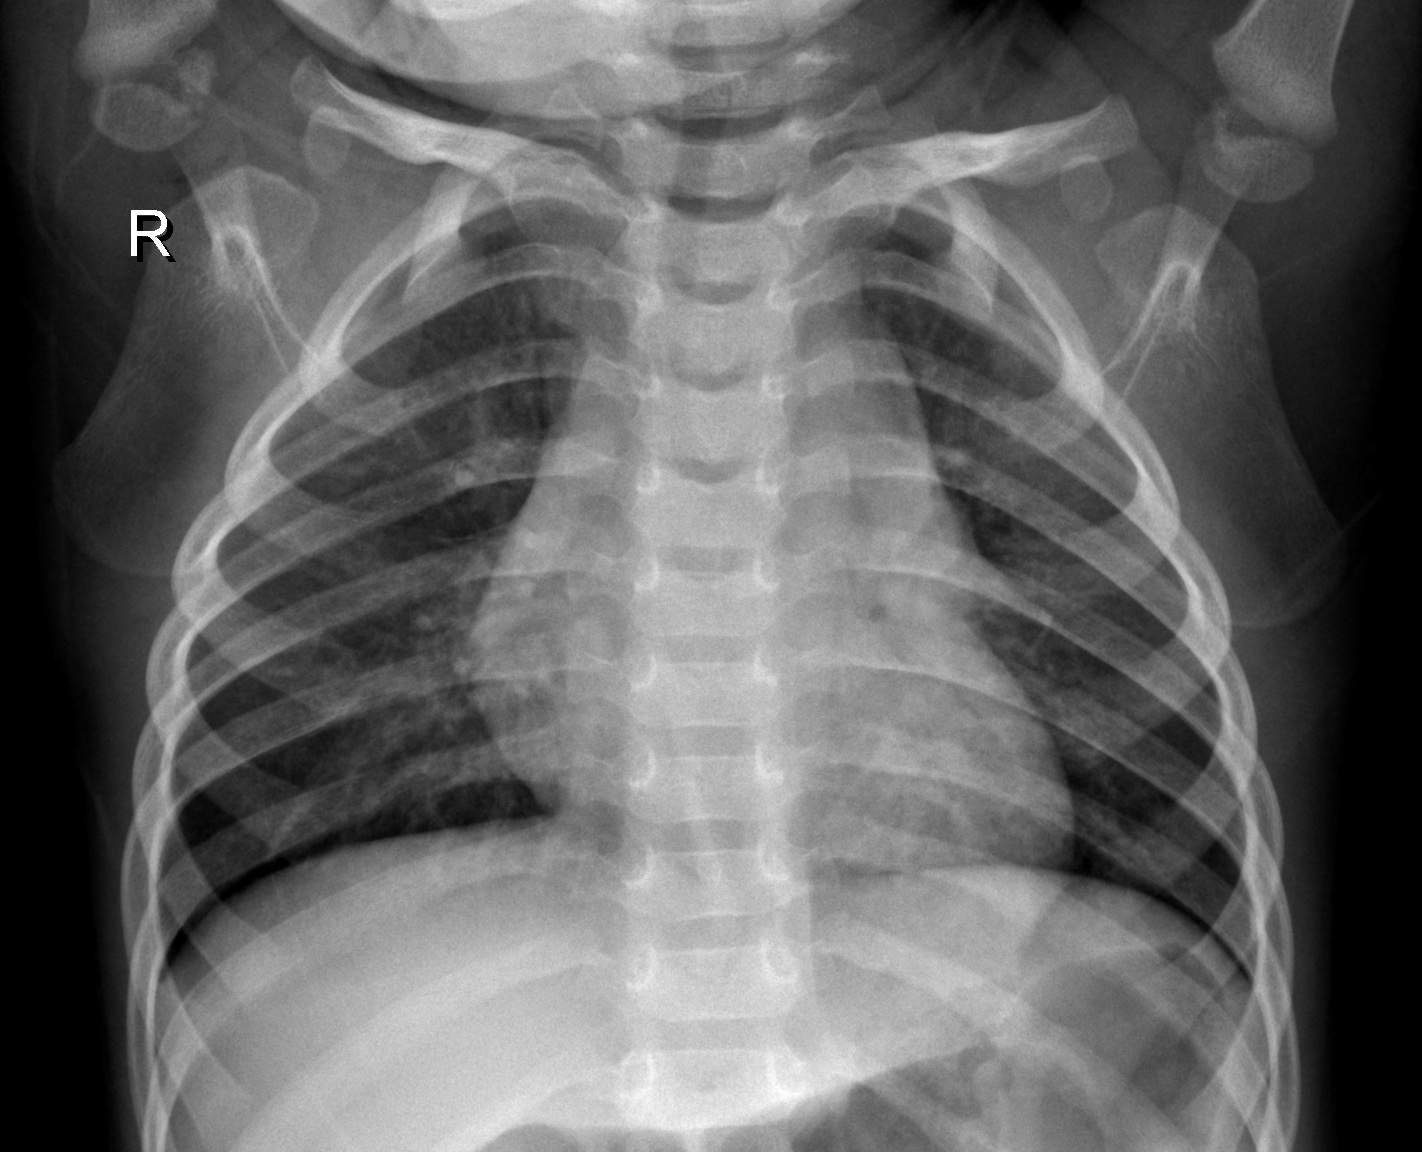

Batéria Pneumonia 

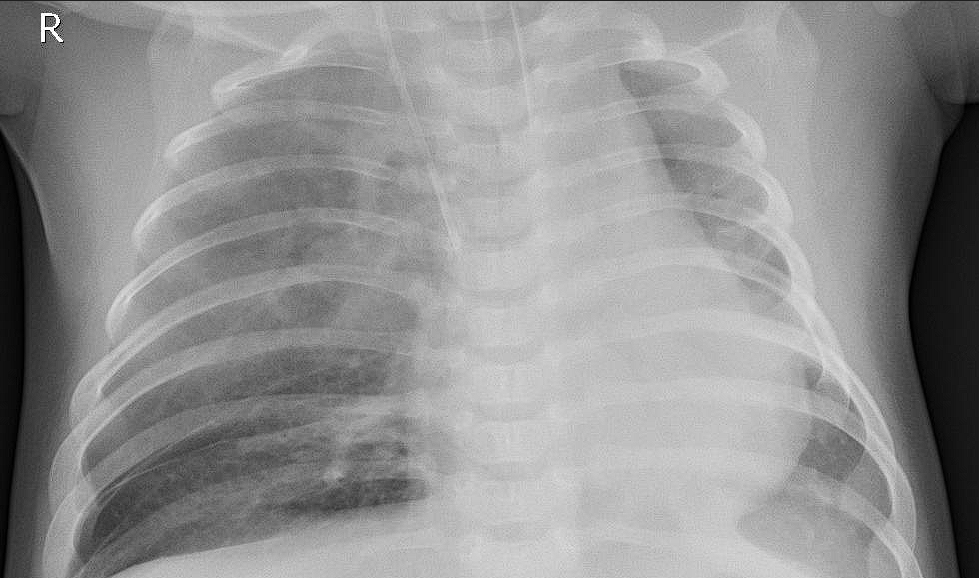

Virus Pneumonia
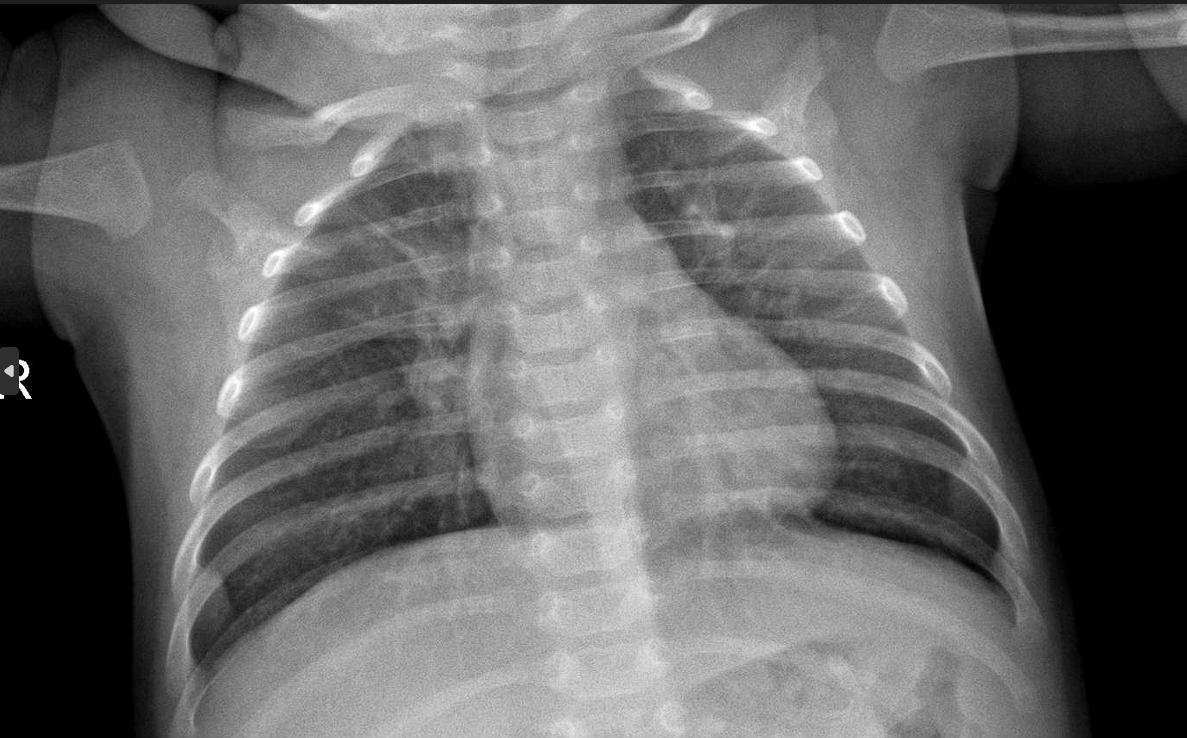



Import des librairies

In [2]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import itertools
from sklearn.metrics import accuracy_score
import seaborn as sns
import gradio
import cv2

Data **Processing**

In [3]:
labels=['PNEUMONIA','NORMAL']
img_size=224
def get_data(data_dir):
  data=[]
  for label in labels:
    path= os.path.join(data_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        resized_arr = cv2.resize(img_arr,(img_size,img_size))  
        data.append([resized_arr, class_num])
      except Exception as e:
        print(e)
  return np.array(data)

In [4]:
train_dir=get_data("/content/drive/MyDrive/ColabNotebooks/chest_Xray/train")
val_dir=get_data("/content/drive/MyDrive/ColabNotebooks/chest_Xray/val")
test_dir=get_data("/content/drive/MyDrive/ColabNotebooks/chest_Xray/test")

<ipython-input-3-239c8a426d58>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


Splittin x and y labels of training, validation and test dataset

In [5]:

x_train=[]
x_val=[]
x_test=[]

y_train=[]
y_val=[]
y_test=[]


for feature, label in train_dir:
  x_train.append(feature)
  y_train.append(label)

for feature, label in val_dir:
  x_val.append(feature)
  y_val.append(label)

for feature, label in test_dir:
  x_test.append(feature)
  y_test.append(label)


In [11]:
positives = []
negatives = []

for i in range(len(y_train)):
  if y_train[i]:
    positives.append(x_train[i])
  else:
    negatives.append(x_train[i])

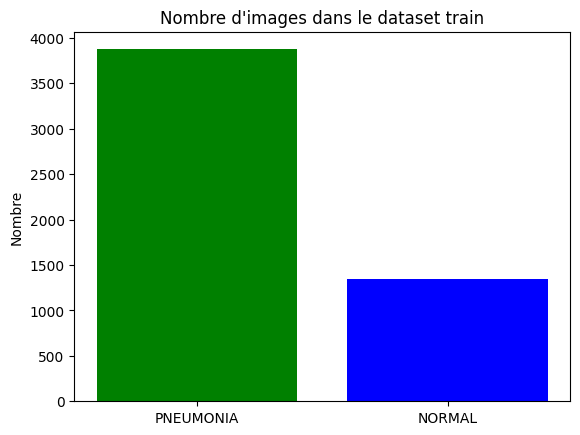

In [12]:
plt.bar(labels, [len(negatives), len(positives)], color=["green", "blue"])
plt.title("Nombre d'images dans le dataset train")
plt.ylabel("Nombre")
plt.show()

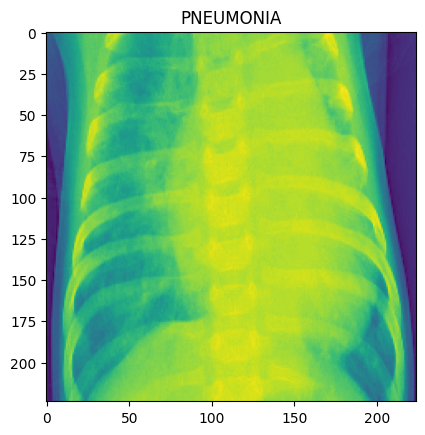

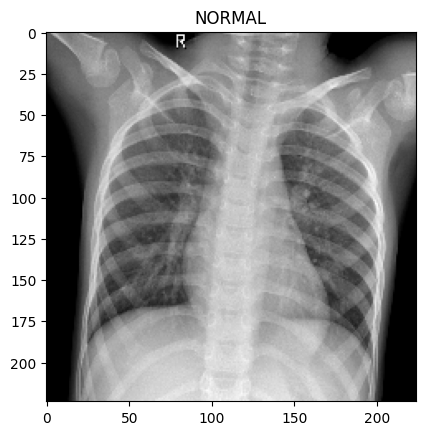

In [17]:
plt.imshow(negatives[2])
plt.title("PNEUMONIA")
plt.show()

plt.imshow(positives[1], cmap="gray")
plt.title("NORMAL")
plt.show()

Perfoming a grayscale normalization to reduce the effect of illumination's difference

In [18]:
#Normalize the data
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [19]:
#Resizing the data for CNN training and testing

x_train = x_train.reshape(-1, img_size,img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size,img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size,img_size, 1)
y_test = np.array(y_test)


In [20]:
x_test[0].shape

(224, 224, 1)

 **Data Augmentation**

 On va utiliser des valeurs d'augmentation  (grayscales, horizontal flip, vertical flip, random_crop, rotations etc...) pour augmenter les example de notre dataset d'entrainement donc la robustes de notre model


In [22]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30, #tourne l'image aléatoirement
    zoom_range=0.2,   #zoom l'image aléatoirement
    width_shift_range=0.1,   #change l'image horizontalement
    height_shift_range=0.1,  #change l'image verticalement
    horizontal_flip=True,     #change l'images aléatoirement
    vertical_flip=False  #change l' images aléatoirement
)

datagen.fit(x_train)

In [24]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))


model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))


model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))


model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=2,
                                            verbose=1,
                                            factor=0.3,
                                            min_lr=0.000001
                                            )

In [26]:
history = model.fit(datagen.flow(x_train,y_train, batch_size=32),
                    epochs= 40,
                    validation_data= datagen.flow(x_val,y_val),
                    callbacks=learning_rate_reduction
                    )

Epoch 1/40
163/163 [==============================] - 39s 144ms/step - loss: 0.6331 - accuracy: 0.8595 - val_loss: 85.7412 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 23s 143ms/step - loss: 0.3482 - accuracy: 0.8668 - val_loss: 61.3670 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - ETA: 0s - loss: 0.2718 - accuracy: 0.8894
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 23s 142ms/step - loss: 0.2718 - accuracy: 0.8894 - val_loss: 42.0630 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 22s 136ms/step - loss: 0.2148 - accuracy: 0.9178 - val_loss: 6.7529 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/40
163/163 [==============================] - 23s 141ms/step - loss: 0.1965 - accuracy: 0.9237 - val_loss: 2.0112 - val_accuracy: 0.5625 - lr: 3.0000e-04
Epoch 6/40
163/163 [==================

**Evaluation Metrics**

In [28]:
print(f'Test loss: { model.evaluate(x_test, y_test)[0]:.4f}')
print(f'Test accuracy: {model.evaluate(x_test, y_test)[1]:.4f}')

20/20 [==============================] - 0s 21ms/step - loss: 0.2544 - accuracy: 0.8958
Test loss: 0.2544
20/20 [==============================] - 0s 18ms/step - loss: 0.2544 - accuracy: 0.8958
Test accuracy: 0.8958


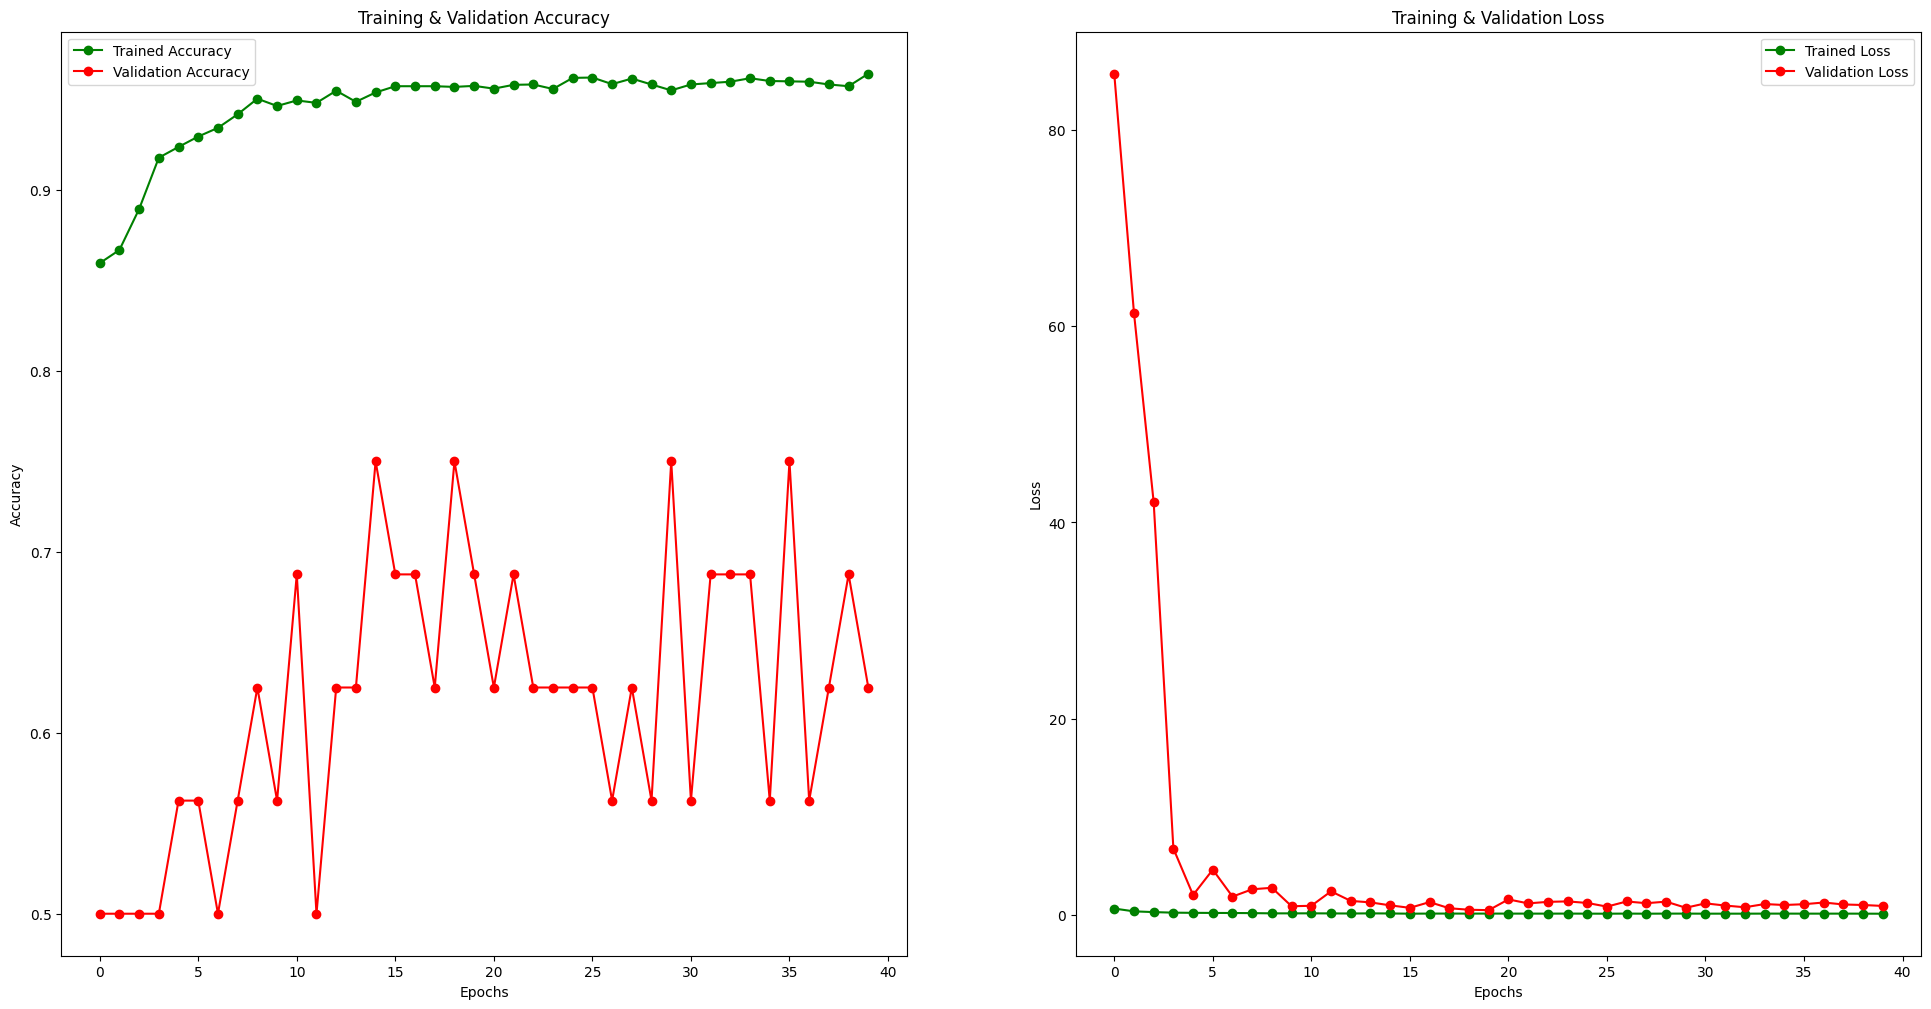

In [29]:
epochs=list(range(40))
fig, ax = plt.subplots(1,2, figsize=(24, 12))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

ax[0].plot(epochs, train_acc, 'go-', label='Trained Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, 'g-o', label='Trained Loss')
ax[1].plot(epochs, val_loss, 'r-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

Prédiction du model

In [30]:
predictions = model.predict(x_test)
for i in range(len(predictions)):
  predictions[i] = 1 if predictions[i]>0.5 else 0
  

20/20 [==============================] - 1s 19ms/step


In [31]:
print(classification_report(y_test, predictions, target_names=['Pneumonia (Classe: 0)', 'Normal (Classe: 1)']))

                       precision    recall  f1-score   support

Pneumonia (Classe: 0)       0.93      0.90      0.92       390
   Normal (Classe: 1)       0.84      0.89      0.86       234

             accuracy                           0.90       624
            macro avg       0.89      0.89      0.89       624
         weighted avg       0.90      0.90      0.90       624



Confusion Matrix

In [32]:
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm, index=['0','1'], columns=['0','1'])
cm

,0,1
0,351,39
1,26,208


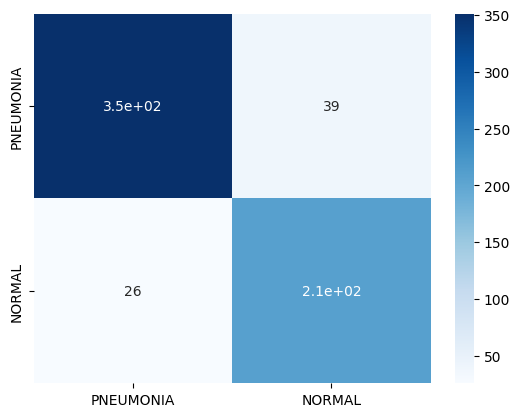

In [36]:
sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=labels, yticklabels=labels)
plt.show()


In [37]:
def pneumoniaPrediction(img):
  img = np.array(img)/255
  img = img.reshape(-1, 224,224,1)
  isPnemonic = model.predict(img)[1]
  imgClass="Normal" if isPnemonic<0.5 else 'Pneumonic'
  return imgClass

In [38]:
pr = model.predict(x_test)
for i in range(len(pr)):
  if pr[i]>0.5:
    pr[i]=1
  else:
    pr[i]=0

20/20 [==============================] - 0s 18ms/step


In [39]:
img = gradio.inputs.Image(shape=(224,224))
label = gradio.outputs.Label(num_top_classes=1)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [ ]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                             title="PneumonIA Detection using Chest X_ray",
                             inputs=img,
                             outputs=label,
                             interpretation='default'
                             )

interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://c8f68c25c1c6350c54.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 22ms/step
